# Bibliotecas

In [1]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pysqldf = lambda q: sqldf(q, globals())

## Importação dos dados

In [2]:
# Transforma os dataframes de Fundos de Investimento dos meses de janeiro e outubro em um único dataframe
df_fi_jan = pd.read_csv('inf_diario_fi_202201.csv', sep=';')
df_fi_out = pd.read_csv('inf_diario_fi_202210.csv', sep=';')
df = pd.concat([df_fi_jan, df_fi_out])

# Dataframe dos Fundos de Investimeto disponiveis na plataforma HUB FINANCEIRO
df_fi_hub = pd.read_csv('PRV_LISTA_FUNDOS.csv', sep=';')


# Tratamento dos dados

In [3]:
# Cria o indice e chama essa coluna de NR_ID
df.index = range(len(df))
df.columns.name = 'NR_ID'

# Cria uma coluna de TIPO e insere FUNDOS HUB para todas as linhas
df_fi_hub['TIPO'] = "Fundos HUB"
# Troca vírgula por ponto e transforma o campo em float
df_fi_hub['RENTANO'] =  df_fi_hub['RENTANO'].str.replace(',','.').astype(np.float64)
df_fi_hub['RENTANO'] =  df_fi_hub['RENTANO'].round(decimals = 2)
df_fi_hub = df_fi_hub.sort_values(by='RENTANO', ascending=False)
df_fi_hub = df_fi_hub.head(10)
print(df_fi_hub)

                                        NOME            CNPJ    DATA_REF  \
52  BRADESCO FIA SUPER ACAO                   71739445000136  31/10/2022   
5   ELITE FUNDO DE INVESTIMENTO EM ACOES      28709046000101  31/10/2022   
14  BNB SELECAO FI ACOES                      63375216000151  31/10/2022   
81  CSHG TOP FC FI MULT                         826903000126  31/10/2022   
17  BRADESCO PRIVATE FIA IBOVESPA ALAVANCADO    463569000193  31/10/2022   
19  BRADESCO FIA MULTI SETORIAL               96498654000166  31/10/2022   
4   BRB FIA INDICE ATIVO                      31937303000169  31/10/2022   
1   BRADESCO PRIME FIC DE FIA ACTIVE          54069422000142  31/10/2022   
82  BTG PACTUAL HEDGE FI MULTIMERCADO           888897000131  31/10/2022   
55  BANPARA TRADICIONAL FIC FI MULT             857361000159  31/10/2022   

    RENTANO        TIPO  
52    18.68  Fundos HUB  
5     17.86  Fundos HUB  
14    16.79  Fundos HUB  
81    16.21  Fundos HUB  
17    15.30  Fundos HUB  
19    1

In [4]:
# Função pra limpar o campo do cpnj
def limpa_formato_cnpj(cnpj):
    cnpj = cnpj.replace('-','').replace('/','').replace('.','')
    return cnpj

# Usa função de limpar o campo CNPJ para tirar os caracteres indesejados
df.dtypes
df['CNPJ_FUNDO'] = df['CNPJ_FUNDO'].apply(limpa_formato_cnpj)

In [5]:
# Calcula a rentabilidade dos fundos através do valor da cota (ultima posicao - primeira posicao)
consulta_rentabilidade = """SELECT tabela.CNPJ_FUNDO,
                                    'Fundos do Mercado' as TIPO,
                                   (tabela.VL_QUOTA_FINAL - tabela.VL_QUOTA) as VL_RENTABILIDADE
                              FROM (
                                    SELECT df.CNPJ_FUNDO, 
                                          df.DT_COMPTC,
                                          df.VL_QUOTA,
                                          LEAD(VL_QUOTA, 1, 0) OVER (PARTITION BY df.CNPJ_FUNDO ORDER BY df.CNPJ_FUNDO, df.DT_COMPTC ASC) as VL_QUOTA_FINAL
                                    FROM df
                                    INNER JOIN ( -- Retorna a primeira e a última data de cada fundo
                                                SELECT MIN(DT_COMPTC) DT_MIN_COMPTC,
                                                       MAX(DT_COMPTC) DT_MAX_COMPTC,
                                                      CNPJ_FUNDO
                                                FROM df 
                                                GROUP BY CNPJ_FUNDO
                                                ) datas ON datas.CNPJ_FUNDO = df.CNPJ_FUNDO AND (datas.DT_MIN_COMPTC = df.DT_COMPTC OR datas.DT_MAX_COMPTC = df.DT_COMPTC)
                                    order by df.CNPJ_FUNDO, df.DT_COMPTC asc
                                    ) tabela
                              GROUP BY tabela.CNPJ_FUNDO
                              HAVING MIN(tabela.DT_COMPTC)
                              ;"""

df_rentabilidade = pysqldf(consulta_rentabilidade)
df_rentabilidade

,CNPJ_FUNDO,TIPO,VL_RENTABILIDADE
0,00017024000153,Fundos do Mercado,2.266354
1,00068305000135,Fundos do Mercado,2.583920
2,00071477000168,Fundos do Mercado,0.864591
3,00073041000108,Fundos do Mercado,2.712895
4,00083181000167,Fundos do Mercado,37.338494
...,...,...,...
25765,97548164000190,Fundos do Mercado,-0.040672
25766,97548167000123,Fundos do Mercado,0.604236
25767,97711801000105,Fundos do Mercado,0.333073
25768,97929197000180,Fundos do Mercado,-0.264595


In [12]:
# Cria um dataframe com a rentabiliade de 50 fundos aleatórios do mercado brasileiro
df_fi_aleatorios = df['CNPJ_FUNDO']
df_fi_aleatorios = df_fi_aleatorios.drop_duplicates()
df_fi_aleatorios.columns = ['NR_ID', 'CNPJ_FUNDO']
df_fi_aleatorios = df_fi_aleatorios.sample(n=50, replace=False)

df_rent_fi_aleatorios = pd.merge(df_fi_aleatorios,df_rentabilidade)
print(df_rent_fi_aleatorios)

        CNPJ_FUNDO               TIPO  VL_RENTABILIDADE
0   44839424000110  Fundos do Mercado          0.011227
1   27056461000132  Fundos do Mercado         -0.125039
2   35693823000124  Fundos do Mercado          9.303851
3   38377445000168  Fundos do Mercado         -0.090216
4   38315751000170  Fundos do Mercado          0.132617
5   24290665000145  Fundos do Mercado          1.812079
6   09720659000197  Fundos do Mercado          0.957831
7   12004245000176  Fundos do Mercado         22.651469
8   10618964000151  Fundos do Mercado         32.495930
9   32893482000142  Fundos do Mercado          0.077024
10  26450646000164  Fundos do Mercado          0.034364
11  04445295000160  Fundos do Mercado          9.442546
12  29250108000114  Fundos do Mercado          0.051319
13  22118303000146  Fundos do Mercado          0.292741
14  23035073000114  Fundos do Mercado          0.009746
15  42447814000119  Fundos do Mercado          0.008846
16  32971916000185  Fundos do Mercado          0

# Gráfico

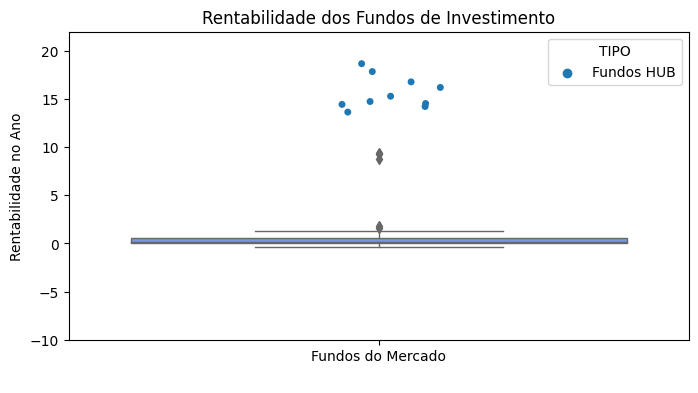

In [14]:
# Monta o boxplot com a rentabilidade dos fundos do mercado brasileiro e um gráfico de dispersão 
# com os 10 fundos de maior rentabilidade da plataforma HUB

# Tamanho do gráfico
plt.figure(figsize =(8, 4))

# Cores dos boxplot
colors = ['#6890F0', '#705898', '#98D8D8']

# Boxplot 
ax = sns.boxplot( x = "TIPO", y ="VL_RENTABILIDADE",data = df_rent_fi_aleatorios, linewidth=1, palette=colors)

# Gráfico de dispersão
ax = sns.stripplot(x = "TIPO", y ="RENTANO",hue="TIPO" , data = df_fi_hub) 

# Tamanho do eixo Y 
plt.ylim(-10,22)

# Adiciona os títulos
plt.title("Rentabilidade dos Fundos de Investimento", loc="center", fontsize=12)
plt.xlabel(" ")
plt.ylabel("Rentabilidade no Ano")

# Plota o gráfico
plt.show()

# Lista dos fundos por quartis

In [15]:
# Cria variáveis e armazena nelas os valores dos quartis referentes aos fundos do mercado brasileiro
df_quartil = pd.DataFrame(df_rent_fi_aleatorios.VL_RENTABILIDADE.quantile([0.25, 0.5, 0.75]))

Q1 = df_quartil.iloc[0][0]
Q2 = df_quartil.iloc[1][0]
Q3 = df_quartil.iloc[2][0]

print(Q1, Q2, Q3)

# Adiciona uma coluna que identifica qual o quartil de cada fundo
df_fi_hub['CD_QUARTIL'] = np.where(df_fi_hub['RENTANO'] < Q1, 'Q1',
                             np.where(df_fi_hub['RENTANO'] < Q2, 'Q2',
                             np.where(df_fi_hub['RENTANO'] < Q3, 'Q3', 'Q4')))

display(df_fi_hub)

0.018377005000000002 0.11915759999999997 0.53472374475


,NOME,CNPJ,DATA_REF,RENTANO,TIPO,CD_QUARTIL
52,BRADESCO FIA SUPER ACAO,71739445000136,31/10/2022,18.68,Fundos HUB,Q4
5,ELITE FUNDO DE INVESTIMENTO EM ACOES,28709046000101,31/10/2022,17.86,Fundos HUB,Q4
14,BNB SELECAO FI ACOES,63375216000151,31/10/2022,16.79,Fundos HUB,Q4
81,CSHG TOP FC FI MULT,826903000126,31/10/2022,16.21,Fundos HUB,Q4
17,BRADESCO PRIVATE FIA IBOVESPA ALAVANCADO,463569000193,31/10/2022,15.30,Fundos HUB,Q4
19,BRADESCO FIA MULTI SETORIAL,96498654000166,31/10/2022,14.75,Fundos HUB,Q4
4,BRB FIA INDICE ATIVO,31937303000169,31/10/2022,14.54,Fundos HUB,Q4
1,BRADESCO PRIME FIC DE FIA ACTIVE,54069422000142,31/10/2022,14.45,Fundos HUB,Q4
82,BTG PACTUAL HEDGE FI MULTIMERCADO,888897000131,31/10/2022,14.23,Fundos HUB,Q4
55,BANPARA TRADICIONAL FIC FI MULT,857361000159,31/10/2022,13.65,Fundos HUB,Q4
